## 3.5. Gradient Boosting

---

In [1]:
import sys
sys.path.insert(1, '../../utils')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ds_functions as ds
from sklearn.model_selection import train_test_split

n_samples = 5
samples = []

for i in range(n_samples):
    dataTrain: pd.DataFrame = pd.read_csv('data/prepared_b_s_sample/data%d.csv' %i, sep=';')
    dataTest: pd.DataFrame = pd.read_csv('data/prepared_test_sample/data%d.csv' %i, sep=';')
        
    samples.append({'dataTrain': dataTrain, 'dataTest': dataTest})

    dataTest_copy = samples[i]['dataTest'].copy(deep=True)

    for feature in dataTest_copy.columns:
        if feature not in samples[i]['dataTrain'].columns:
            samples[i]['dataTest'] = samples[i]['dataTest'].drop(feature, axis=1)

<Figure size 600x450 with 0 Axes>

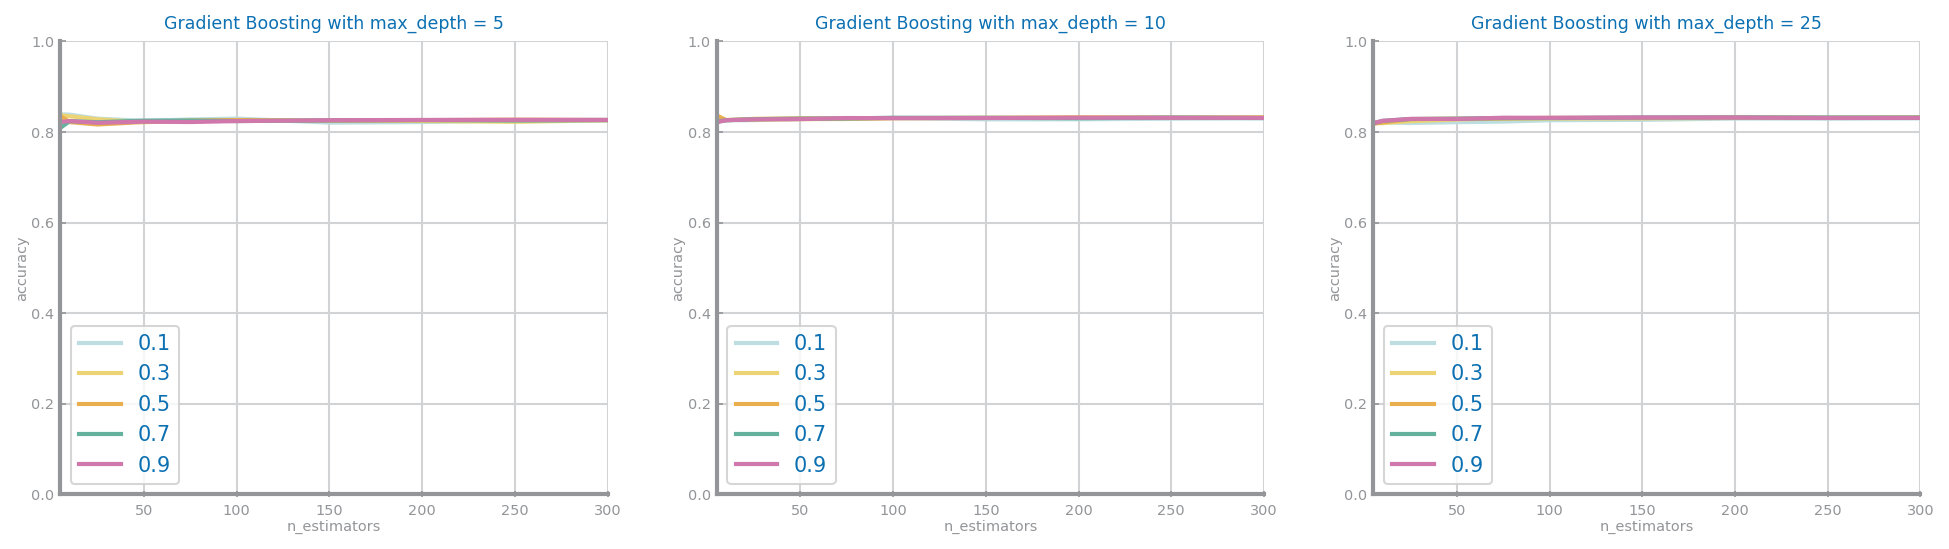

Best results per sample:
	Sample 0: depth=10, learning_rate=0.300000 and n_estimators=300 ==> accuracy=0.89
	Sample 1: depth=5, learning_rate=0.100000 and n_estimators=10 ==> accuracy=0.83
	Sample 2: depth=10, learning_rate=0.500000 and n_estimators=5 ==> accuracy=0.82
	Sample 3: depth=5, learning_rate=0.100000 and n_estimators=5 ==> accuracy=0.84
	Sample 4: depth=25, learning_rate=0.300000 and n_estimators=300 ==> accuracy=0.89


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.ensemble import GradientBoostingClassifier
import ds_functions as ds

labels = [False, True]
target = 'exp'

n_estimators = [5, 10, 25, 50, 75, 100, 150, 200, 250, 300]
max_depths = [5, 10, 25]
learning_rate = [.1, .3, .5, .7, .9]

cols = len(max_depths)

sample_best = [(0, .0, 0)] * n_samples
sample_best_gb = [None] * n_samples
sample_last_best = [0] * n_samples

trnY, trnX, tstY, tstX = [], [], [], []
for i in range(n_samples):    
    trnY.append(samples[i]['dataTrain'].pop(target).values)
    trnX.append(samples[i]['dataTrain'].values)
    tstY.append(samples[i]['dataTest'].pop(target).values)
    tstX.append(samples[i]['dataTest'].values)

# Run algorithm and plot results
plt.figure()
fig, axs = plt.subplots(1, cols, figsize=(16, 4), squeeze=False)
for k in range(cols):
    d = max_depths[k]
    values = {}
    for lr in learning_rate:
        values[lr] = []
        for _ in range(len(n_estimators)):
            values[lr].append(0)
    for i in range(n_samples):
        for lr in learning_rate:
            yvalues = []
            for n in n_estimators:
                gb = GradientBoostingClassifier(n_estimators=n, max_depth=d, learning_rate=lr)
                gb.fit(trnX[i], trnY[i])
                prdY = gb.predict(tstX[i])
                yvalues.append(metrics.accuracy_score(tstY[i], prdY))
                # Check if accuracy is better than best in current sample
                if yvalues[-1] > sample_last_best[i]:
                    sample_best[i] = (d, lr, n)
                    sample_last_best[i] = yvalues[-1]
                    sample_best_gb[i] = gb
            # Increment total accuracy for current (learning_rate, n_estimators)
            for n in range(len(yvalues)):
                values[lr][n] += yvalues[n]
    # Normalize
    for lr in values:
        for n in range(len(values[lr])):
            values[lr][n] /= n_samples
            
    ds.multiple_line_chart(n_estimators, values, ax=axs[0, k], title='Gradient Boosting with max_depth = %d' % d,
                           xlabel='n_estimators', ylabel='accuracy', percentage=True)
plt.show()

print('Best results per sample:')
for i in range(n_samples):
    print('\tSample %d: depth=%d, learning_rate=%f and n_estimators=%d ==> accuracy=%1.2f'
        % (i, *sample_best[i], sample_last_best[i]))

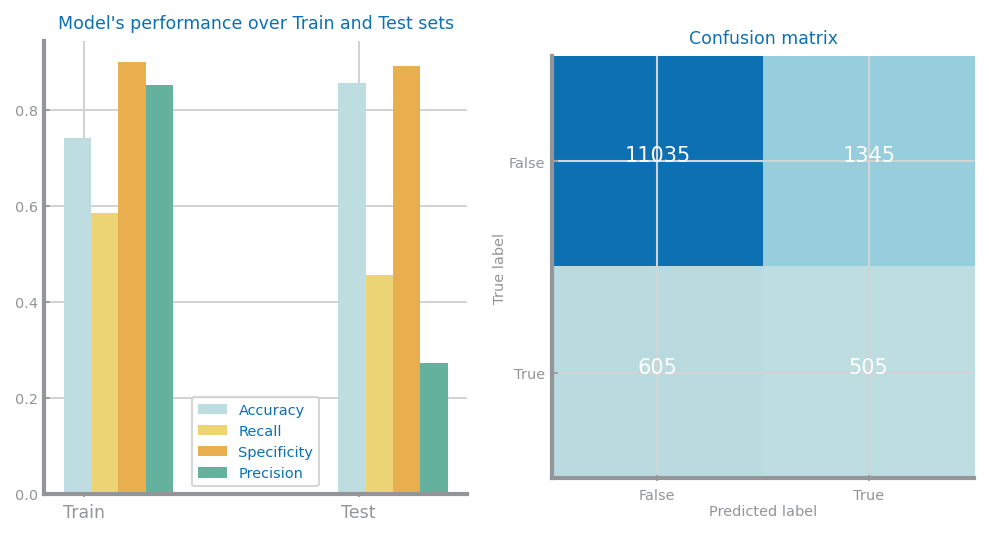

In [4]:
y_train_all = []
prd_train_all = []
y_test_all = []
prd_test_all = []

for i in range(n_samples):
    y_train_all.extend(trnY[i])
    prd_train_all.extend(sample_best_gb[i].predict(trnX[i]))
    y_test_all.extend(tstY[i])
    prd_test_all.extend(sample_best_gb[i].predict(tstX[i]))
    
ds.plot_evaluation_results(labels, y_train_all, prd_train_all, y_test_all, prd_test_all, showXTickLabels=True)

In [5]:
mean = np.mean(sample_last_best)
std = np.std(sample_last_best)
confidences = (0.95, 0.99)
t_st = (1.812, 2.764)

print(f'Mean value: {round(mean, 3)}')

for c in range(len(confidences)):
    conf = confidences[c]
    minAcc = mean - t_st[c] * std / (10**0.5)
    maxAcc = mean + t_st[c] * std / (10**0.5)
    print(f'{int(conf*100)}% cofidence interval for accuracy: [' +
        f'{round(minAcc, 3)},{round(maxAcc, 3)}]')

Mean value: 0.855
95% cofidence interval for accuracy: [0.837,0.874]
99% cofidence interval for accuracy: [0.828,0.883]


### Overfitting study

In [ ]:
values = []

for k in range(len(max_depths)):
    values.append(
        {'test': [0 for _ in n_estimators], 
         'train': [0 for _ in n_estimators]})

for i in range(n_samples):
    lr = sample_best[i][1]

    for k in range(cols):
        d = max_depths[k]

        yvalues = []
        yvalues_train = []
        for n in n_estimators:
            gb = GradientBoostingClassifier(n_estimators=n, max_depth=d, learning_rate=lr)
            gb.fit(trnX[i], trnY[i])
            prdY = gb.predict(tstX[i])
            prdY_train = gb.predict(trnX[i])
            yvalues.append(metrics.accuracy_score(tstY[i], prdY))
            yvalues_train.append(metrics.accuracy_score(trnY[i], prdY_train))
        values[k]['test'] = [values[k]['test'][v] + 
            yvalues[v]/n_samples for v in range(len(yvalues))]
        values[k]['train'] = [values[k]['train'][v] +
            yvalues_train[v]/n_samples for v in range(len(yvalues_train))]

plt.figure()
fig, axs = plt.subplots(1, len(max_depths), figsize=(16, 4), squeeze=False)
for k in range(len(max_depths)):
    d = max_depths[k]
    ds.multiple_line_chart(n_estimators, values[k], ax=axs[0, k], title='Gradient boosting with depth=%d' % (d),
        xlabel='n_estimators', ylabel='accuracy', percentage=True)
plt.show()

### Summary

---

***How does performance changes with the number of estimators?***


***How does performance changes of learning rate?***


***How do models improve with the increase of max_depth?***


***What is the best parametrisation (max_depth, number of estimators and learning rate)?***


***Is the accuracy achieved good enough?***


***What is the largest kind of errors?***


***Is it possible to identify overfitting?***